In [2]:
import numpy as np
import torch
torch.set_default_dtype(torch.double)
import random
random.seed(666)
np.random.seed(666)
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

from clusterless import preprocess
from sklearn.metrics import accuracy_score, roc_auc_score

### Data

In [3]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [4]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [6]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

rand_idx = np.arange(n_trials)
train_idx = rand_idx[:int(.8*n_trials)]
test_idx = rand_idx[int(.8*n_trials):]

train_features = np.vstack([unsorted_trials[i][:,2:] for i in train_idx])
train_channels = np.hstack([unsorted_trials[i][:,1] for i in train_idx])
train_y = choices[train_idx].argmax(1)
test_y = choices[test_idx].argmax(1)

In [7]:
n_time_bins = 10
binning = np.arange(0, 1.5, step=(1.5 - 0)/n_time_bins)
n_trials = stim_on_times.shape[0]
spike_train = np.concatenate(unsorted_trials)[:,[0,2,3,4]]

In [8]:
trial_idx = []
time_idx = []
all_trials = []
for k in range(n_trials):
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        time_idx.append(np.ones_like(time_bin[:,0]) * t)
        trial_idx.append(np.ones_like(time_bin[:,0]) * k)
        all_trials.append(time_bin)
time_idx = np.concatenate(time_idx)
trial_idx = np.concatenate(trial_idx)
all_trials = np.concatenate(all_trials)

In [9]:
train_mask = np.sum([trial_idx == idx for idx in train_idx], axis=0).astype(bool)
train_trials = all_trials[train_mask]
train_time_idx = time_idx[train_mask]
train_trial_idx = trial_idx[train_mask]

In [10]:
test_mask = np.sum([trial_idx == idx for idx in test_idx], axis=0).astype(bool)
test_trials = all_trials[test_mask]
test_time_idx = time_idx[test_mask]
test_trial_idx = trial_idx[test_mask]

pre-compute mu and cov from training trials

In [10]:
# sub_weights_lst = []
# sub_means_lst = []
# sub_covs_lst = []
# for channel in np.unique(train_channels):
#     sub_spike_features = train_features[train_channels == channel]
#     # a minimum of 2 points required for MoG
#     if len(sub_spike_features) > 2: 
#         sub_gmm = GaussianMixture(n_components=1, 
#                           covariance_type='full',
#                           init_params='k-means++', 
#                           verbose=0)
#         sub_gmm.fit(sub_spike_features)
#         sub_labels = sub_gmm.predict(sub_spike_features)
#         sub_weights = len(sub_spike_features)/len(train_features)
#         sub_weights_lst.append(sub_weights)
#         sub_means_lst.append(sub_gmm.means_)
#         sub_covs_lst.append(sub_gmm.covariances_)
# sub_weights = np.hstack(sub_weights_lst)
# sub_means = np.vstack(sub_means_lst)
# sub_covs = np.vstack(sub_covs_lst)

In [11]:
# C = len(sub_weights)
# gmm = GaussianMixture(n_components=C, 
#                       covariance_type='full')
# gmm.weights_ = sub_weights
# gmm.means_ = sub_means
# gmm.covariances_ = sub_covs
# gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [12]:
C = 10
gmm = GaussianMixture(n_components=C, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(init_params='k-means++', n_components=10, verbose=1)

In [13]:
gmm.means_.shape

(10, 3)

pre-compute time-varying lambda's from training trials

In [14]:
lambdas = []

for k in train_idx:
    mask = np.logical_and(spike_train[:,0] >= stim_on_times[k]-0.5,
                          spike_train[:,0] <= stim_on_times[k]+1
                         )
    trial = spike_train[mask,:]
    trial[:,0] = trial[:,0] - trial[:,0].min()
    time_bins = np.digitize(trial[:,0], binning, right=False)-1
    time_bins_lst = []
    for t in range(n_time_bins):
        time_bin = trial[time_bins == t, 1:]
        cluster_idx = gmm.predict(time_bin)
        # probs = gmm.predict_proba(time_bin)
        probs_array = np.zeros((C, 2))
        for j in range(C):
            if choices[k].argmax() == 0:
                # probs_array[j, 0] = np.sum(probs[cluster_idx == j])
                probs_array[j, 0] = np.sum(cluster_idx == j)
            else:
                # probs_array[j, 1] = np.sum(probs[cluster_idx == j])
                probs_array[j, 1] = np.sum(cluster_idx == j)
        time_bins_lst.append(probs_array)
    lambdas.append(time_bins_lst)
lambdas = np.array(lambdas)

In [15]:
lambdas.shape

(212, 10, 10, 2)

In [16]:
n_left = np.sum(train_y==0)
n_right = np.sum(train_y==1)
empirical_lams = lambdas.sum(0) / np.array([n_left, n_right])
empirical_lams = empirical_lams.transpose(1,0,2)

In [17]:
# p
n_right / (n_right + n_left)

0.25

In [18]:
diff_empirical_lams = empirical_lams[:,:,0] - empirical_lams[:,:,1]

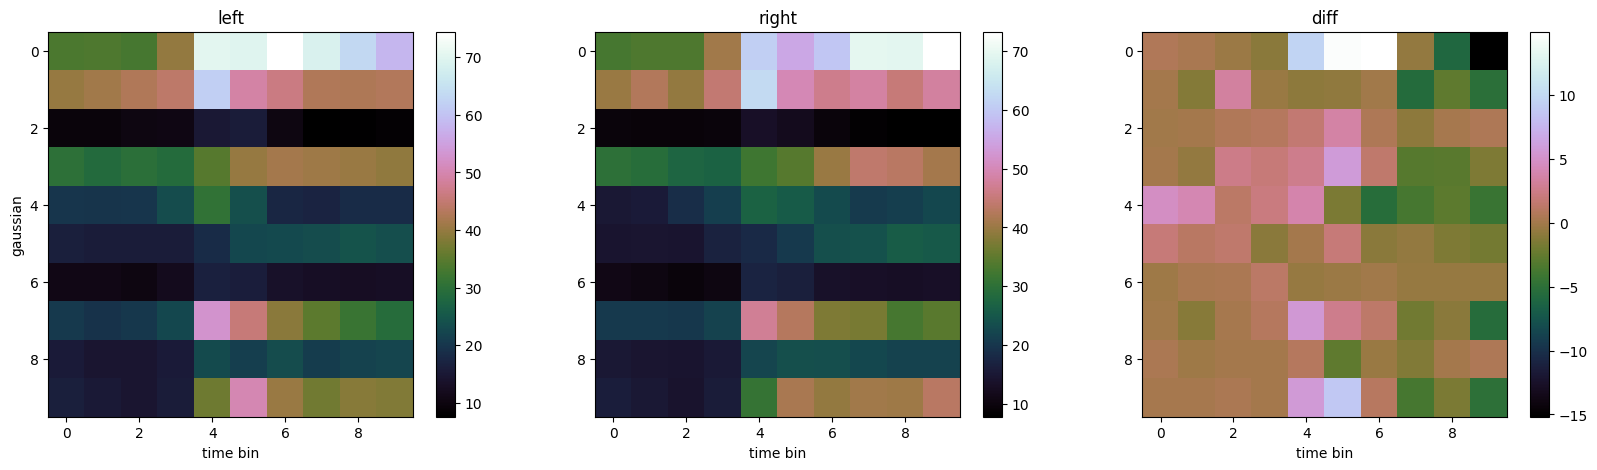

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(empirical_lams[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(empirical_lams[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(diff_empirical_lams, aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

### ELBO

In [11]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [21]:
def compute_elbo_einsum(s, y, r, mu, cov, norm_lam, t_idxs, K, T, C):

    # expected log-likelihood ( E_q(z)[log p(s,z|y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( y^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
    #                    + (1-y^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
    elbo_1 = 0; log_dens = []
    for j in range(C):
        log_dens.append(
            torch.tensor(
                multivariate_normal.logpdf(s, mu[j], cov[j])
            )
        )
        elbo_1 += torch.einsum('i,i->', r[:,j], log_dens[-1])
            
    elbo_2 = torch.tensor(
        [ torch.einsum('ij,il,j->', r[t_idxs[t]], y[t_idxs[t]], norm_lam[:,t,1]) +
          torch.einsum('ij,il,j->', r[t_idxs[t]], 1-y[t_idxs[t]], norm_lam[:,t,0]) for t in range(T) ]
    ).sum()
        
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_3 = - torch.einsum('ij,ij->', safe_log(r), r)
    
    elbo = elbo_1 + elbo_2 + elbo_3 
    
    # print(f'elbo 1: {elbo_1}')
    # print(f'elbo 2: {elbo_2}')
    # print(f'elbo 3: {elbo_3}')
    
    return elbo, torch.vstack(log_dens).T

In [22]:
K = len(train_idx)
C = len(gmm.means_)
T = n_time_bins
s = torch.tensor(train_trials)
train_time_idx = torch.tensor(train_time_idx)
empirical_lams = torch.tensor(empirical_lams)

r = torch.ones((train_trials.shape[0], C)) / C
t_idxs = [torch.argwhere(train_time_idx == t).reshape(-1) for t in range(T)]

y = torch.zeros(train_trials.shape[0])
for k in range(K):
    y[train_trial_idx == k] = train_y[k]
y = y.reshape(-1,1)

norm_lam = safe_log(empirical_lams) - safe_log(empirical_lams.sum(0))

In [97]:
%%time
elbo, log_dens = compute_elbo_einsum(s=train_trials, 
                    y=y, 
                    r=r, 
                    mu=gmm.means_, 
                    cov=gmm.covariances_, 
                    norm_lam=norm_lam, 
                    t_idxs=t_idxs,
                    K=len(train_idx),
                    T=n_time_bins,
                    C=len(gmm.means_))
print(elbo)

elbo 1: -563739400097358.0
elbo 2: -6160204.9759907955
elbo 3: 3507173.5276382715
tensor(-5.6374e+14)
CPU times: user 1min 1s, sys: 6.68 s, total: 1min 8s
Wall time: 8.6 s


In [11]:
# K = len(train_idx)
# C = 10
# T = n_time_bins
# s = torch.tensor(train_trials)
# train_time_idx = torch.tensor(train_time_idx)

# r = torch.ones((train_trials.shape[0], C)) / C
# t_masks = torch.vstack([train_time_idx == t for t in range(T)])
# t_idxs = [torch.argwhere(train_time_idx == t).reshape(-1) for t in range(T)]

# y = torch.zeros(train_trials.shape[0])
# for k in range(K):
#     y[train_trial_idx == k] = train_y[k]
# y = y.reshape(-1,1)

# loaded_mu = torch.tensor(np.load('empirical_means.npy'))
# loaded_cov = torch.tensor(np.load('empirical_covs.npy'))
# loaded_lam = torch.tensor(np.load('empirical_lambdas.npy'))
# norm_lam = safe_log(loaded_lam) - safe_log(loaded_lam.sum(0))

In [14]:
# %%time
# elbo, log_dens = compute_elbo_einsum(s=s, 
#                     y=y, 
#                     r=r, 
#                     mu=loaded_mu, 
#                     cov=loaded_cov, 
#                     norm_lam=norm_lam, 
#                     t_idxs=t_idxs,
#                     K=len(train_idx),
#                     T=n_time_bins,
#                     C=C)
# print(elbo)

elbo 1: -248465052.18659902
elbo 2: -1502471.0581118108
elbo 3: 1368129.286682262
tensor(-2.4860e+08)
CPU times: user 1.93 s, sys: 132 ms, total: 2.06 s
Wall time: 269 ms


### CAVI

In [23]:
def cavi_einsum(s, y, means, covs, init_lams, K, T, C, D, t_idxs, max_iter=20, eps=1e-10):
    
    # initialize
    r = torch.ones((s.shape[0], C)) / C
    lam = init_lams.clone()
    mu, cov = torch.tensor(means), torch.tensor(covs)
    norm_lam = safe_log(lam) - safe_log(lam.sum(0))
    
    # compute ELBO
    elbo, log_dens = compute_elbo_einsum(s, y, r, mu, cov, norm_lam, t_idxs, K, T, C)
    convergence = 1.
    elbos = [elbo]
    print(f'initial elbo: {elbos[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged   
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp(log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( y^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
        #                    + (1-y^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )            
        for t in range(T):
            r[t_idxs[t]] = torch.exp( log_dens[t_idxs[t]] + \
                      torch.einsum('il,j->ij', y[t_idxs[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-y[t_idxs[t]], norm_lam[:,t,0])
            )
            r[t_idxs[t]] = torch.einsum('ij,i->ij', r[t_idxs[t]], 1/r[t_idxs[t]].sum(1))
            
            
        # update lambda^t_j1, lambda^t_j0
        # a nested loop is faster & more memory efficient than fully vectorized version
        for j in range(C):
            no_j_idx = torch.cat([torch.arange(j), torch.arange(j+1,C)])
            lams_sum_no_j = lam[no_j_idx,:,:].sum(0)
            for t in range(T):
                num1 = torch.einsum('i,il,->', r[t_idxs[t],j], y[t_idxs[t]], lams_sum_no_j[t,1])
                denom1 = np.einsum('ij,il->', r[t_idxs[t]][:,no_j_idx], y[t_idxs[t]])
                num0 = torch.einsum('i,il,->', r[t_idxs[t],j], 1-y[t_idxs[t]], lams_sum_no_j[t,0])
                denom0 = np.einsum('ij,il->', r[t_idxs[t]][:,no_j_idx], 1-y[t_idxs[t]])
                lam[j,t,1], lam[j,t,0] = num1 / denom1, num0 / denom0
        norm_lam = safe_log(lam) - safe_log(lam.sum(0))

        
        # update means and covs
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] 
            ) for j in range(C)]
        
        # compute ELBO
        elbo, log_dens = compute_elbo_einsum(s, y, r, mu, cov, norm_lam, t_idxs, K, T, C)
        elbos.append(elbo)
        convergence = elbos[-1] - elbos[-2]
        
        print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r, lam, mu, cov, elbos

In [17]:
%%time
_, _, _, _, _ = cavi_einsum(s=s, 
                            y=y, 
                            means=loaded_mu, 
                            covs=loaded_cov, 
                            init_lams=loaded_lam, 
                            K=len(train_idx), 
                            T=n_time_bins, 
                            C=C, 
                            D=train_trials.shape[1], 
                            t_idxs=t_idxs, 
                            max_iter=2)

/tmp/ipykernel_95886/4026374818.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu, cov = torch.tensor(means), torch.tensor(covs)


elbo 1: -248465052.18659902
elbo 2: -1502471.0581118108
elbo 3: 1368129.286682262
initial elbo: -248599393.96
tensor(22.4317)
elbo 1: -7795449.136358567
elbo 2: -1261355.455638079
elbo 3: 113819.29435871658
iter: 1 elbo: -8942985.30.
tensor(22.1631)
elbo 1: -7798858.103489151
elbo 2: -1261604.880544474
elbo 3: 117990.4991923542
iter: 2 elbo: -8942472.48.
reached max iter allowed.
CPU times: user 14 s, sys: 753 ms, total: 14.7 s
Wall time: 1.84 s


### Run

In [24]:
%%time
enc_r, enc_lam, enc_mu, enc_cov, enc_elbo = cavi_einsum(s=torch.tensor(train_trials), 
                                                        y=y, 
                                                        means=gmm.means_, 
                                                        covs=gmm.covariances_, 
                                                        init_lams=empirical_lams, 
                                                        K=len(train_idx), 
                                                        T=n_time_bins, 
                                                        C=len(gmm.means_), 
                                                        D=train_trials.shape[1], 
                                                        t_idxs=t_idxs, 
                                                        max_iter=50)

initial elbo: -115303255.13
iter: 1 elbo: -8956515.80.
iter: 2 elbo: -8955877.33.
iter: 3 elbo: -8955242.16.
iter: 4 elbo: -8954485.97.
iter: 5 elbo: -8953638.01.
iter: 6 elbo: -8952803.17.
iter: 7 elbo: -8952092.62.
iter: 8 elbo: -8951573.75.
iter: 9 elbo: -8951216.77.
iter: 10 elbo: -8950939.77.
iter: 11 elbo: -8950693.98.
iter: 12 elbo: -8950461.92.
iter: 13 elbo: -8950236.91.
iter: 14 elbo: -8950013.35.
iter: 15 elbo: -8949782.42.
iter: 16 elbo: -8949529.05.
iter: 17 elbo: -8949228.13.
iter: 18 elbo: -8948841.17.
iter: 19 elbo: -8948323.51.
iter: 20 elbo: -8947654.29.
iter: 21 elbo: -8946837.59.
iter: 22 elbo: -8945817.46.
iter: 23 elbo: -8944441.43.
iter: 24 elbo: -8942504.39.
iter: 25 elbo: -8939846.79.
iter: 26 elbo: -8936529.92.
iter: 27 elbo: -8932901.12.
iter: 28 elbo: -8929340.39.
iter: 29 elbo: -8925980.52.
iter: 30 elbo: -8922714.65.
iter: 31 elbo: -8919430.73.
iter: 32 elbo: -8916317.91.
iter: 33 elbo: -8913676.70.
iter: 34 elbo: -8911549.75.
iter: 35 elbo: -8909751.29.
i

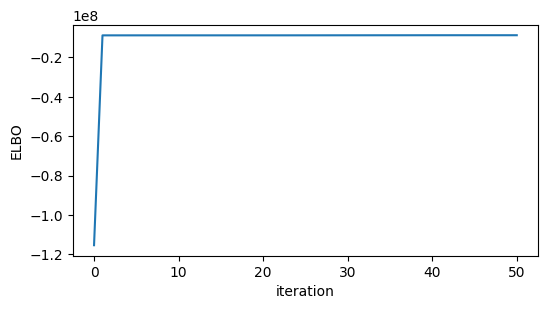

In [25]:
plt.figure(figsize=(6,3))
plt.plot(enc_elbo)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

In [26]:
init_gmm = {
    'weights': gmm.weights_,
    'mu': gmm.means_,
    'cov': gmm.covariances_,
}
np.save(save_path + f'init_gmm_c{C}_t{n_time_bins}.npy', init_gmm)

In [27]:
res_enc = {
    'r': enc_r, 
    'lam': enc_lam,
    'mu': enc_mu,
    'cov': enc_cov,
    'elbo': enc_elbo,
}
np.save(save_path + f'res_enc_c{C}_t{n_time_bins}_count.npy', res_enc)

In [28]:
diff_lam = enc_lam[:,:,0] - enc_lam[:,:,1]

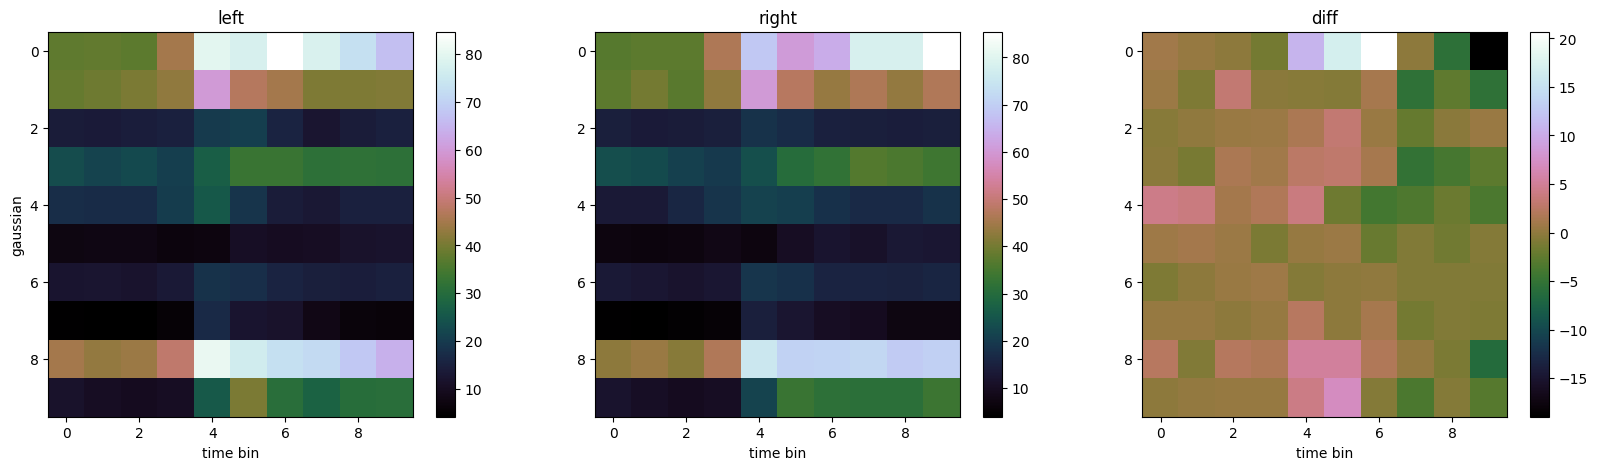

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
f1 = ax1.imshow(enc_lam[:,:,0], aspect='auto', cmap='cubehelix')
ax1.set_title('left')
ax1.set_xlabel('time bin')
ax1.set_ylabel('gaussian')
fig.colorbar(f1, ax=ax1);
f2 = ax2.imshow(enc_lam[:,:,1], aspect='auto', cmap='cubehelix')
ax2.set_title('right')
ax2.set_xlabel('time bin')
fig.colorbar(f2, ax=ax2);
f3 = ax3.imshow(diff_lam, aspect='auto', cmap='cubehelix')
ax3.set_title('diff')
ax3.set_xlabel('time bin')
fig.colorbar(f3, ax=ax3);

### Decoder

In [12]:
def compute_elbo_einsum(s, r, nu, nu_k, mu, cov, norm_lam, p, K, T, C, t_idxs):
    
    # expected log-likelihood ( E_q(z,y)[log p(s,z,y)] )
    # sum_{ktij} r_{ijt}^k * log(dN(s_i^kt; mu_j, cov_j))
    
    # sum_{ktij} r_{ijt}^k * ( nu^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
    #                    + (1-nu^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
    elbo_1 = 0; log_dens = []
    for j in range(C):
        log_dens.append(
            torch.tensor(
                multivariate_normal.logpdf(s, mu[j], cov[j])
            )
        )
        elbo_1 += torch.einsum('i,i->', r[:,j], log_dens[-1])
            
    elbo_2 = torch.tensor(
        [ torch.einsum('ij,il,j->', r[t_idxs[t]], nu[t_idxs[t]], norm_lam[:,t,1]) +
          torch.einsum('ij,il,j->', r[t_idxs[t]], 1-nu[t_idxs[t]], norm_lam[:,t,0]) for t in range(T) ]
    ).sum()
    
    # sum_k nu^k * logp + (1-nu^k) * log(1-p)
    elbo_3 = torch.sum(nu_k * safe_log(p) + (1-nu_k) * safe_log(1-p))
    
    # entropy of q(z) ( E_q(z)[log q(z)] )
    # sum_{ktij} log(r_{ijt}^k) * r_{ijt}^k
    elbo_4 = - torch.einsum('ij,ij->', safe_log(r), r)
    
    # entropy of q(y) ( E_q(y)[log q(y)] )
    # sum_k log(nu^k) * nu^k
    elbo_5 = - torch.sum(safe_log(nu_k) * nu_k)
    
    elbo = elbo_1 + elbo_2 + elbo_3 + elbo_4 + elbo_5
    
    # print(f'elbo 1: {elbo_1}')
    # print(f'elbo 2: {elbo_2}')
    # print(f'elbo 3: {elbo_3}')
    # print(f'elbo 4: {elbo_4}')
    # print(f'elbo 5: {elbo_5}')
    
    return elbo, torch.vstack(log_dens).T

In [60]:
K = len(test_idx)
C = 300
T = n_time_bins
s = torch.tensor(test_trials)
test_trial_idx = torch.tensor(test_trial_idx)
test_time_idx = torch.tensor(test_time_idx)

p = torch.tensor([.25])
r = torch.ones((test_trials.shape[0], C)) / C
t_idxs = [torch.argwhere(test_time_idx == t).reshape(-1) for t in range(T)]
k_idxs = [torch.argwhere(test_trial_idx == k).reshape(-1) for k in test_idx]

nu_k = torch.rand(K)
nu = torch.zeros(s.shape[0])
for k in range(K):
    nu[test_trial_idx == np.unique(test_idx)[k]] = nu_k[k]
nu = nu.reshape(-1,1)

/tmp/ipykernel_99574/115155357.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_trial_idx = torch.tensor(test_trial_idx)
/tmp/ipykernel_99574/115155357.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_time_idx = torch.tensor(test_time_idx)


In [116]:
%%time
elbo, log_dens = compute_elbo_einsum(s=s, 
                    r=r, 
                    nu=nu, 
                    nu_k=nu_k, 
                    mu=loaded_mu, 
                    cov=loaded_cov, 
                    norm_lam=norm_lam, 
                    p=torch.tensor([.25]), 
                    K=K, 
                    T=T, 
                    C=C, 
                    t_idxs=t_idxs)
print(elbo)

elbo 1: -58621779.0725267
elbo 2: -365227.81503440754
elbo 3: -59.97898017562313
elbo 4: 332900.8448450175
elbo 5: 10.71176111470439
tensor(-58654155.3099)
CPU times: user 505 ms, sys: 12 ms, total: 517 ms
Wall time: 66.9 ms


In [16]:
def safe_divide(x, y):
    return torch.clip(x / y, min = 0, max = 1)

In [17]:
def cavi_einsum(s, means, covs, lam, init_nu, init_nu_k, K, T, C, D, k_idxs, t_idxs, max_iter=20, eps=1e-10):
    
    # initialize
    p = torch.tensor([.25]) 
    r = torch.ones((s.shape[0], C)) / C
    mu, cov = torch.tensor(means), torch.tensor(covs)
    norm_lam = safe_log(lam) - safe_log(lam.sum(0))
    
    nu_k = init_nu_k.clone()
    nu = init_nu.clone()
    
    # compute initial ELBO
    elbo, log_dens = compute_elbo_einsum(s, r, nu, nu_k, mu, cov, norm_lam, p, K, T, C, t_idxs)
    elbos = [elbo]
    convergence = 1.
    print(f'initial elbo: {elbos[-1]:.2f}')
    
    it = 1
    while convergence > eps or convergence < 0:  # while ELBO not converged 
        # update q(z)
        # r_{ijt}^k = rho_{ijt}^k / sum_j rho_{ijt}^k
        # rho_{ijt}^k = exp(log(dN(s_i^kt; mu_j, cov_j)) + 
        #                      ( nu^k * (log(lambda^t_{j1}) - log(sum_j' lambda^t_{j'1})) 
        #                    + (1-nu^k) * (log(lambda^t_{j0}) - log(sum_j' lambda^t_{j'0})) )
        for t in range(T):
            r[t_idxs[t]] = torch.exp( log_dens[t_idxs[t]] + \
                      torch.einsum('il,j->ij', nu[t_idxs[t]], norm_lam[:,t,1]) + \
                      torch.einsum('il,j->ij', 1-nu[t_idxs[t]], norm_lam[:,t,0])
            )
            r[t_idxs[t]] = torch.einsum('ij,i->ij', r[t_idxs[t]], 1/r[t_idxs[t]].sum(1))
        
        
        for k in range(K):
            y_tilde0 = safe_log(1-p)
            y_tilde1 = safe_log(p)
            for t in range(T):
                t_k_idxs = np.intersect1d(k_idxs[k], t_idxs[t])
                y_tilde0 += torch.einsum('ij,j->', r[t_k_idxs], norm_lam[:,t,0])
                y_tilde1 += torch.einsum('ij,j->', r[t_k_idxs], norm_lam[:,t,1])
            # y_tilde explode to 0 after exp(); need offset to ensure y_tilde stay in range
            offset = 1 / (torch.min(torch.tensor([y_tilde0, y_tilde1])) / -745) 
            y_tilde0, y_tilde1 = torch.exp(y_tilde0 * offset), torch.exp(y_tilde1 * offset)
            nu_k[k] = safe_divide(y_tilde1, y_tilde0 + y_tilde1)
            nu[k_idxs[k]] = nu_k[k] 
            

        # update posterior param p
        p = nu_k.sum() / K
    
        # update means and covs
        norm = r.sum(0)
        mu = torch.einsum('j,ij,ip->jp', 1/norm, r, s)
        cov = [torch.einsum(
            ',i,ip,id->pd', 1/norm[j], r[:,j], s-mu[j], s-mu[j] 
            ) for j in range(C)]
        
        # compute ELBO
        elbo, log_dens = compute_elbo_einsum(s, r, nu, nu_k, mu, cov, norm_lam, p, K, T, C, t_idxs)
        elbos.append(elbo)
        convergence = elbos[-1] - elbos[-2]

        print(f'iter: {it} elbo: {elbos[-1]:.2f}.')
        it +=1 
        if it > max_iter: 
            print('reached max iter allowed.')
            break
            
    if abs(convergence) <= eps:
        print('converged.')
    
    return r, nu_k, mu, cov, p, elbos

In [61]:
res_enc = np.load(save_path + f'res_enc_c{C}_t{n_time_bins}_count.npy', 
                  allow_pickle=True).item()
enc_lam = res_enc['lam']
enc_mu = res_enc['mu']
enc_cov = res_enc['cov']

In [62]:
dec_r, dec_nu_k, dec_mu, dec_cov, dec_p, dec_elbos = cavi_einsum(
            s=s, 
            means=enc_mu, 
            covs=torch.stack(enc_cov), 
            lam=enc_lam, 
            init_nu=nu, 
            init_nu_k=nu_k, 
            K=K, 
            T=T, 
            C=C, 
            D=s.shape[1], 
            k_idxs=k_idxs, 
            t_idxs=t_idxs, 
            max_iter=30)

/tmp/ipykernel_99574/1188627496.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu, cov = torch.tensor(means), torch.tensor(covs)


initial elbo: -8740366846.72
iter: 1 elbo: -1937587.22.
iter: 2 elbo: -1926445.01.
iter: 3 elbo: -1923314.03.
iter: 4 elbo: -1921852.92.
iter: 5 elbo: -1920958.90.
iter: 6 elbo: -1920344.45.
iter: 7 elbo: -1919885.59.
iter: 8 elbo: -1919531.69.
iter: 9 elbo: -1919245.88.
iter: 10 elbo: -1918998.41.
iter: 11 elbo: -1918776.71.
iter: 12 elbo: -1918589.13.
iter: 13 elbo: -1918415.19.
iter: 14 elbo: -1918247.72.
iter: 15 elbo: -1918083.40.
iter: 16 elbo: -1917920.18.
iter: 17 elbo: -1917764.23.
iter: 18 elbo: -1917619.36.
iter: 19 elbo: -1917486.01.
iter: 20 elbo: -1917360.65.
iter: 21 elbo: -1917243.95.
iter: 22 elbo: -1917133.99.
iter: 23 elbo: -1917024.98.
iter: 24 elbo: -1916904.12.
iter: 25 elbo: -1916775.79.
iter: 26 elbo: -1916642.90.
iter: 27 elbo: -1916516.67.
iter: 28 elbo: -1916424.15.
iter: 29 elbo: -1916352.54.
iter: 30 elbo: -1916291.37.
reached max iter allowed.


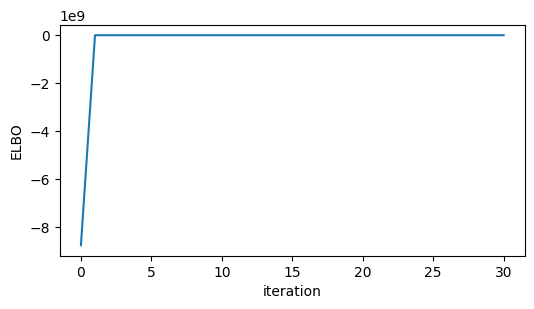

In [63]:
plt.figure(figsize=(6,3))
plt.plot(dec_elbos)
plt.xlabel('iteration')
plt.ylabel('ELBO')
pass

In [64]:
dec_nu_k

tensor([1.9011e-03, 9.8864e-01, 5.0000e-01, 3.8358e-04, 2.2321e-03, 1.6026e-03,
        5.9773e-04, 6.8729e-04, 2.2422e-03, 3.6088e-04, 2.1277e-03, 1.2979e-04,
        2.1877e-04, 9.5420e-04, 1.0616e-03, 2.7779e-05, 3.3784e-03, 7.9202e-05,
        9.4564e-06, 5.7013e-04, 2.9855e-05, 8.1301e-04, 9.9342e-01, 8.1880e-05,
        1.4706e-02, 8.0645e-03, 8.7500e-01, 7.0892e-05, 4.4143e-06, 5.0000e-01,
        9.2308e-01, 9.9705e-01, 9.2308e-01, 9.9174e-01, 2.1598e-03, 9.8462e-01,
        1.6722e-03, 6.4767e-04, 1.9380e-03, 5.0429e-04, 9.3333e-01, 9.4118e-01,
        4.6275e-04, 5.0000e-01, 5.7353e-05, 1.3706e-04, 9.9771e-01, 9.9138e-01,
        9.9779e-01, 9.5238e-01, 3.6179e-04, 4.3478e-03, 1.9957e-05])

In [65]:
# C = 10 T = 10 acc = 0.87 auc = 0.86
# C = 10 T = 15 acc = 0.86 auc = 0.83
# C = 50 T = 15 acc = 0.96 auc = 0.97 (7 mins)
# C = 50 T = 10 acc = 0.96 auc = 0.97 
# C = 100 T = 10 acc = 0.96 auc = 0.996 (30 mins)
# C = 150 T = 10 acc = 1.  auc = 1. (1 hr)
# C = 200 T = 10 acc = 1. auc = 1.  (1.5 hrs)
# C = 300 T = 10 acc = .98 auc = 1. (3 hrs)

print(accuracy_score(test_y, 1.*(dec_nu_k > .5)))
print(roc_auc_score(test_y, dec_nu_k))

0.9811320754716981
1.0


In [66]:
res_dec = {
    'r': dec_r, 
    'nu': dec_nu_k,
    'y': test_y,
    'mu': dec_mu,
    'cov': dec_cov,
    'p': dec_p,
    'elbo': dec_elbos,
}
np.save(save_path +  f'res_dec_c{C}_t{n_time_bins}_count.npy', res_dec)